# Visualize Output Samples from DreamBooth Checkpoints


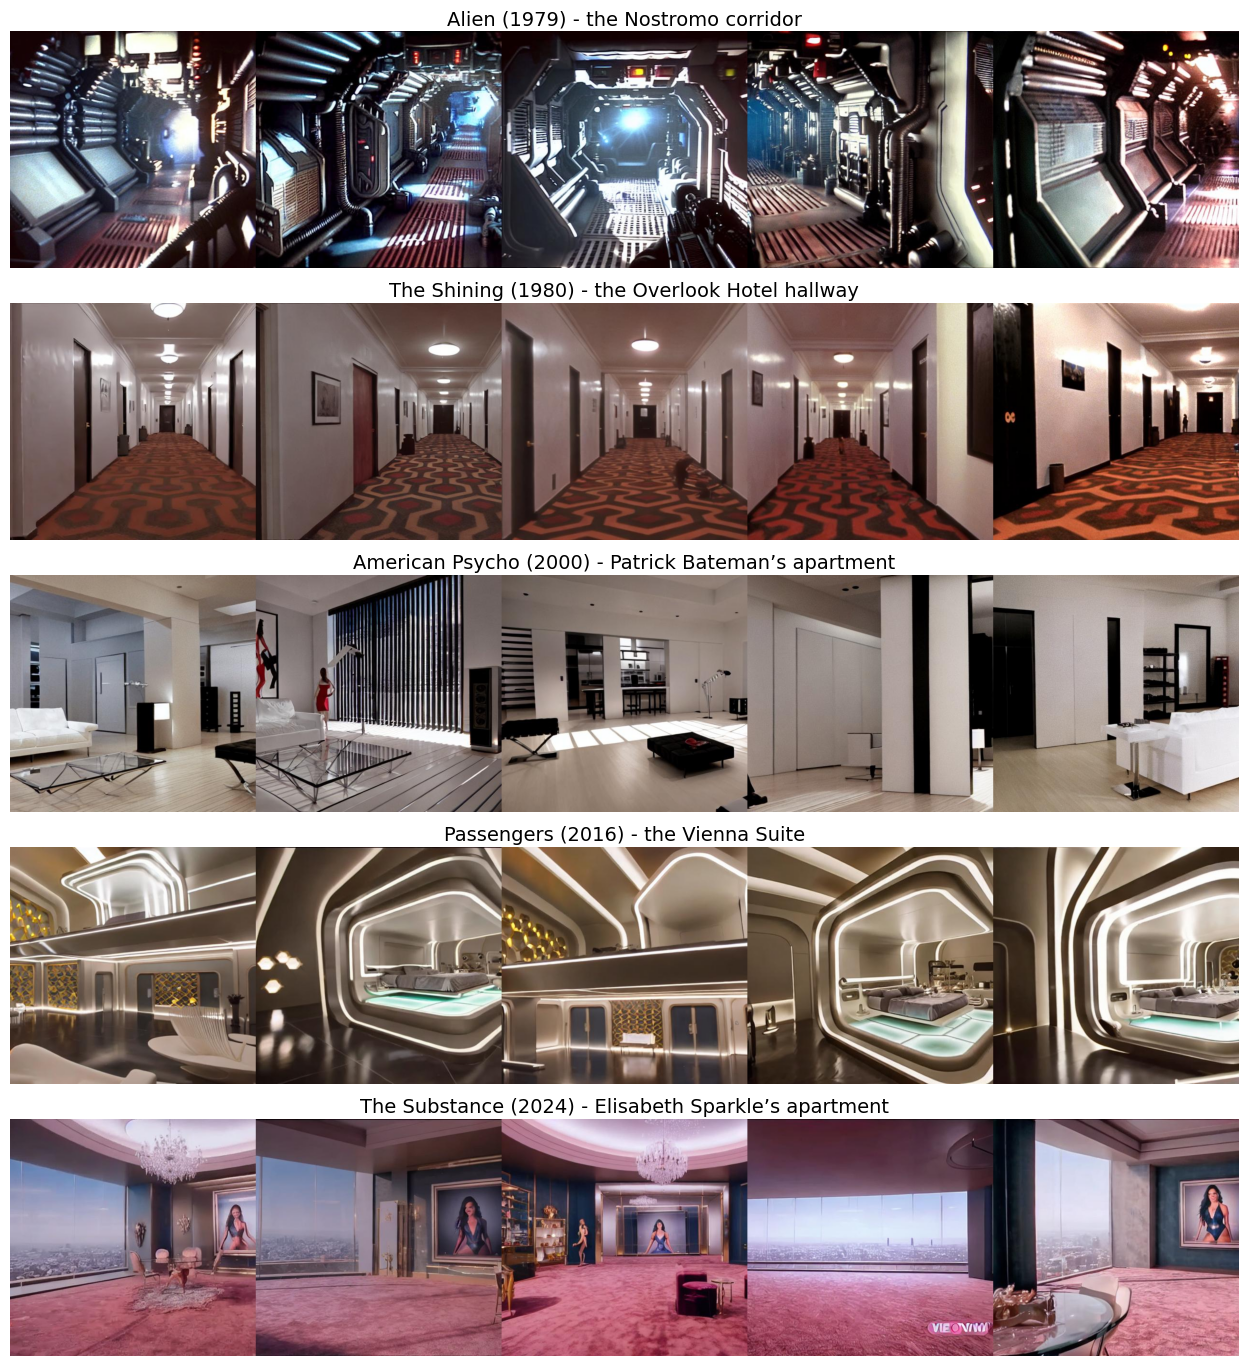

In [18]:
# ==== DreamBooth samples collage: 1 image per movie (row) with caption ====
from pathlib import Path
from typing import Optional
from PIL import Image
import matplotlib.pyplot as plt

# --- Configure paths ---
samples_root = Path("sample")  # folder sits next to the notebook

MOVIES = ["alien", "shining", "as", "pas", "sub"]

# Movie code -> caption shown above the row
MOVIE_LABELS = {
    "alien": "Alien (1979) - the Nostromo corridor",
    "shining": "The Shining (1980) - the Overlook Hotel hallway",
    "as": "American Psycho (2000) - Patrick Bateman’s apartment",
    "pas": "Passengers (2016) - the Vienna Suite",
    "sub": "The Substance (2024) - Elisabeth Sparkle’s apartment",
}

# Optionally force a specific image name per movie (relative to sample/ or sample/{movie}/)
FORCED_SAMPLE = {
    "alien": "alien.jpg",
    "shining": "shining.jpg",
    "as": "as.jpg",
    "pas": "pas.jpg",
    "sub": "sub.jpg",
}

IMG_EXTS = (".png", ".jpg", ".jpeg", ".webp")

# Output (set to None to skip saving)
save_path = Path("reports/db_samples.png")

# ---- NEW: export sizing tweaks (minimal) ----
TARGET_WIDTH_PX = 2560  # aim for ≥ 2560 px width (your row images are ~2560x512)
SAVE_DPI = 200  # 2560 px / 200 dpi = 12.8 inches


# --- Helpers (robust to flat or per-movie folders) ---
def first_sample_image(movie: str) -> Optional[Path]:
    # 1) flat: sample/alien.jpg, sample/as.png, ...
    for p in sorted(samples_root.glob(f"{movie}*")):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            return p
    # 2) subfolder: sample/{movie}/*
    movie_dir = samples_root / movie
    if movie_dir.exists():
        for p in sorted(movie_dir.iterdir()):
            if p.is_file() and p.suffix.lower() in IMG_EXTS:
                return p
        # 3) nested: sample/{movie}/sample/*
        nested = movie_dir / "sample"
        if nested.exists():
            for p in sorted(nested.iterdir()):
                if p.is_file() and p.suffix.lower() in IMG_EXTS:
                    return p
    return None


def resolve_sample_for_movie(movie: str) -> Optional[Path]:
    forced = FORCED_SAMPLE.get(movie)
    if forced:
        cand = Path(forced)
        if cand.is_absolute() and cand.exists():
            return cand
        for cand in (
            samples_root / forced,
            samples_root / movie / forced,
            samples_root / movie / "sample" / forced,
        ):
            if cand.exists():
                return cand
        print(f"[warn] Forced file not found for {movie}: {forced}")
    return first_sample_image(movie)


def _first_size(default=(2560, 512)):
    for m in MOVIES:
        p = resolve_sample_for_movie(m)
        if p is not None:
            try:
                return Image.open(p).size  # (w, h)
            except Exception:
                pass
    return default


img_w_px, img_h_px = _first_size()
fig_w_in = max(TARGET_WIDTH_PX, img_w_px) / SAVE_DPI
row_h_in = (img_h_px / SAVE_DPI) + 0.2  # small extra for the title

# --- Build the collage ---
rows, cols = len(MOVIES), 1
fig_w, fig_h = fig_w_in, rows * row_h_in
fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), constrained_layout=False)
if rows == 1:
    axes = [axes]

for r, movie in enumerate(MOVIES):
    ax = axes[r]
    img_path = resolve_sample_for_movie(movie)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()

    title = MOVIE_LABELS.get(movie, movie)
    ax.set_title(title, fontsize=14, pad=5)  # caption close to image

    if img_path is None:
        ax.text(
            0.5,
            0.5,
            f"No sample found\n(sample/{movie}/)",
            ha="center",
            va="center",
            fontsize=10,
        )
        continue

    im = Image.open(img_path).convert("RGB")
    ax.imshow(im, aspect="auto")

# Tighten spacing so titles sit closer to images
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.02, right=0.98, hspace=0.15)

if save_path:
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=SAVE_DPI, pad_inches=0.02)

plt.show()